In [1]:
import sys
print(sys.executable)

D:\Predicting_Stock_Prices\myenv\Scripts\python.exe


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# Load sentiment data from multiple files
def load_sentiment_data():
    files = [
        "C:\\Users\\Admin\\Downloads\\archive (5)\\all-data.csv", 
        "C:\\Users\\Admin\\Downloads\\archive (5)\\FinancialPhraseBank\\Sentences_75Agree.txt", 
        "C:\\Users\\Admin\\Downloads\\archive (5)\\FinancialPhraseBank\\Sentences_AllAgree.txt",
        "C:\\Users\\Admin\\Downloads\\archive (5)\\FinancialPhraseBank\\Sentences_50Agree.txt",
        "C:\\Users\\Admin\\Downloads\\archive (5)\\FinancialPhraseBank\\Sentences_66Agree.txt"
    ]
    data = []
    for file in files:
        with open(file, "r", encoding='ISO-8859-1', errors='ignore') as f:
            for line in f.readlines():
                parts = line.rsplit("@", 1)
                if len(parts) == 2:
                    text, sentiment = parts
                    data.append((text.strip(), sentiment.strip()))
    return pd.DataFrame(data, columns=["Text", "Sentiment"])

sentiment_df = load_sentiment_data()

In [6]:
print("Dataset Info:")
print(sentiment_df.info())
print("\nFirst 5 Rows:")
print(sentiment_df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       14780 non-null  object
 1   Sentiment  14780 non-null  object
dtypes: object(2)
memory usage: 231.1+ KB
None

First 5 Rows:
                                                Text Sentiment
0  According to Gran , the company has no plans t...   neutral
1  With the new production plant the company woul...  positive
2  For the last quarter of 2010 , Componenta 's n...  positive
3  In the third quarter of 2010 , net sales incre...  positive
4  Operating profit rose to EUR 13.1 mn from EUR ...  positive


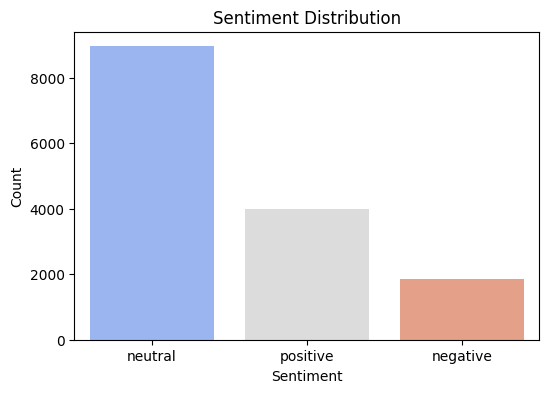

In [7]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=sentiment_df['Sentiment'], palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
# Encode sentiment labels
encoder = LabelEncoder()
sentiment_df['Sentiment_Label'] = encoder.fit_transform(sentiment_df['Sentiment'])

In [9]:
# Initialize sentiment analysis models
sia = SentimentIntensityAnalyzer()
bert_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use cpu


In [10]:
# Hybrid sentiment analysis: Use VADER first, BERT if uncertain
def hybrid_sentiment_analysis(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"  # Default to neutral if text is empty
    
    vader_score = sia.polarity_scores(text)['compound']
    
    if vader_score >= 0.3:  # Lower threshold for detecting positive
        return "positive"
    elif vader_score <= -0.3:  # Lower threshold for detecting negative
        return "negative"
    
    bert_result = bert_pipeline(text)[0]['label']
    return bert_result.lower()

In [11]:
# Apply hybrid sentiment analysis
sentiment_df['Sentiment_Category'] = sentiment_df['Text'].apply(hybrid_sentiment_analysis)

In [12]:
# Sentiment category is already assigned
sentiment_df['Sentiment_Score'] = sentiment_df['Sentiment_Category']

In [13]:
# Optimize TF-IDF by removing stopwords
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(sentiment_df['Text'])
y = sentiment_df['Sentiment_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
import joblib

In [15]:
# Save the trained model and vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(model, "sentiment_model.pkl")
print("Models saved successfully!")

Models saved successfully!


In [16]:
# Evaluate sentiment model
predictions = model.predict(X_test)
print("Sentiment Model Accuracy:", accuracy_score(y_test, predictions))

Sentiment Model Accuracy: 0.9191474966170501


In [17]:
# Optimize BERT processing by batching uncertain texts
uncertain_texts = sentiment_df[sentiment_df['Sentiment_Category'] == "neutral"]['Text'].tolist()

def batch_bert_analysis(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_results = bert_pipeline(batch)
        results.extend([res['label'].lower() for res in batch_results])
    return results

# Process neutral & weakly negative texts with BERT
uncertain_texts = sentiment_df[sentiment_df['Sentiment_Category'].isin(["neutral", "negative"])]['Text'].tolist()

if uncertain_texts:
    bert_results = batch_bert_analysis(uncertain_texts)
    uncertain_indices = sentiment_df[sentiment_df['Sentiment_Category'].isin(["neutral", "negative"])].index
    sentiment_df.loc[uncertain_indices, 'Sentiment_Category'] = bert_results[:len(uncertain_indices)]

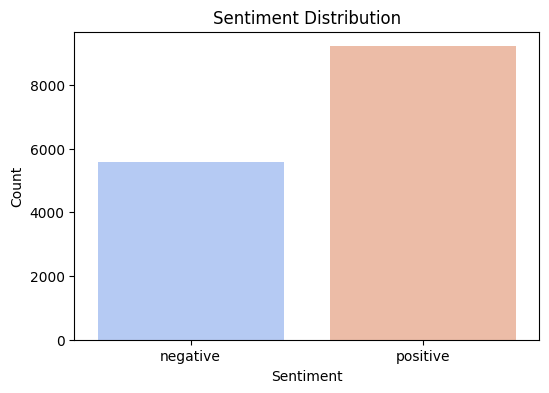

In [18]:
# Visualize sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=sentiment_df['Sentiment_Category'], palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()